# 0. 필요한 모듈 불러오기

In [2]:
!git clone https://github.com/meetps/pytorch-semseg.git

fatal: destination path 'pytorch-semseg' already exists and is not an empty directory.


In [3]:
import os
# pytorch-semseg 폴더로 작업 디렉토리 변경
os.chdir('pytorch-semseg')
# requirements.txt 파일이 있는지 확인하고, 패키지 설치
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import functools
import zipfile
import os
import shutil
import random

from ptsemseg.models.utils import get_upsampling_weight
from ptsemseg.loss import cross_entropy2d

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms.functional as TF
from torchvision import datasets, transforms, models

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터셋 준비

In [5]:
# 현재 작업 디렉토리 확인
current_directory = os.getcwd()
print(f"현재 작업 디렉토리: {current_directory}")

os.chdir('/root')
print(f"새 작업 디렉토리: {os.getcwd()}")

현재 작업 디렉토리: /root/pytorch-semseg
새 작업 디렉토리: /root


## 1.1 zip 파일 풀기

In [6]:
zip_file_path = 'archive.zip'
extract_to_path= '.'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

## 1.2 train 데이터셋, val 데이터셋 분리

In [7]:
# 원본 이미지 및 마스크 경로
images_src_dir = './png_images/IMAGES'
masks_src_dir = './png_masks/MASKS'

# 타겟 디렉토리 설정
train_images_dir = 'dataset/train/images'
train_masks_dir = 'dataset/train/masks'
val_images_dir = 'dataset/val/images'
val_masks_dir = 'dataset/val/masks'

# 타겟 디렉토리가 존재하지 않으면 생성
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_masks_dir, exist_ok=True)

# 원본 이미지 디렉토리의 모든 파일 목록 가져오기
all_images = os.listdir(images_src_dir)

# 이미지를 랜덤하게 섞기
random.shuffle(all_images)

# 검증셋과 훈련셋으로 나누기
val_images = all_images[:100]
train_images = all_images[100:]

# 이미지와 매칭되는 마스크 파일 복사
for img_name in val_images:
    # 이미지 파일 복사
    shutil.copy(os.path.join(images_src_dir, img_name), os.path.join(val_images_dir, img_name))
    mask_name = img_name.replace('img', 'seg')
    shutil.copy(os.path.join(masks_src_dir, mask_name), os.path.join(val_masks_dir, mask_name))

for img_name in train_images:
    # 이미지 파일 복사
    shutil.copy(os.path.join(images_src_dir, img_name), os.path.join(train_images_dir, img_name))
    mask_name = img_name.replace('img', 'seg') 
    shutil.copy(os.path.join(masks_src_dir, mask_name), os.path.join(train_masks_dir, mask_name))

print("이미지와 마스크 파일의 분할이 완료되었습니다.")

이미지와 마스크 파일의 분할이 완료되었습니다.


## 1.3 데이터 로더에 데이터를 로드 

In [22]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))
        
        self.images = [img for img in self.images if os.path.isfile(os.path.join(images_dir, img))]
        self.masks = [msk for msk in self.masks if os.path.isfile(os.path.join(masks_dir, msk))]

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0)
            
        return image, mask
# 데이터 전처리
# resize, to tensor, normalization
# 이외에도 centor crop. gr# 이외에도 centor crop. grapyscale, random affine transformations
# 이외에도 centor crop. grapyscale, random affine transformations
# random crop, ramdom horizontal flip, color jitter, 등의 방법이 있음.

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.ToTensor(),
])

train_images_dir = './dataset/train/images'
train_masks_dir = './dataset/train/masks'
val_images_dir = './dataset/val/images'
val_masks_dir = './dataset/val/masks'

train_dataset = SegmentationDataset(train_images_dir, train_masks_dir, transform=transform, target_transform=target_transform)
val_dataset = SegmentationDataset(val_images_dir, val_masks_dir, transform=transform, target_transform=target_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [23]:
# Mask 범위 확인
for images, masks in train_loader:
    print('mask size:', masks.size())
    max_value = masks.max().item()
    print(f'Max value in masks: {max_value}')
    break  # 첫 번째 배치의 최댓값만 확인하기 위해 반복문 종료

mask size: torch.Size([8, 1, 256, 256])
Max value in masks: 54.0


## 1.4 데이터 시각화 

배치의 크기: torch.Size([8, 3, 256, 256])
이미지의 크기: torch.Size([3, 256, 256])


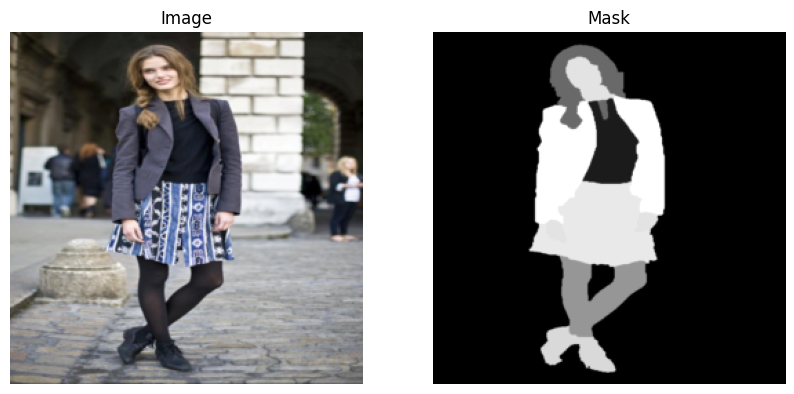

In [24]:
## 데이터 시각화
# 정규화 역변환 함수
def denormalize(image_tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # CHW -> HWC
    image = std * image + mean  # 정규화 역변환
    # clipping: 0보다 작으면 0, 1보다 크면 1로 변환
    # 값이 비정상적으로 크거나 작아지는 것을 방지하는 역할
    image = np.clip(image, 0, 1)  # [0, 1] 범위로 클리핑
    # 이미지 시각화 라이브러리(OpecV, matplotlib 등)은 이미지 데이터를 0에서 255 범위의
    # 8비트 정수 형태로 다루기 때문에 정규화된 [0,1] [0,255]로 변환
    image = (image * 255).astype(np.uint8)  # [0, 1] -> [0, 255]
    return image

def imshow(image_tensor, mask_tensor, mean, std):
    image = denormalize(image_tensor, mean, std)  # 정규화 역변환 적용
    # 채널 차원 제거, cpu로 이동, numpy 배열로 변환
    mask = mask_tensor.squeeze(0).cpu().numpy()  
    # mask = (mask * 255).astype(np.uint8)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    # color map을 지정하는 인자, 그레이스케일 컬러 맵을 사용하여 이미지를 시각화함.
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    
    plt.show()

# 데이터셋에서 배치 하나를 로드하여 시각화
# 데이터 로더는 각 배치를 (input, target) 형태로 반환함.
# iter는 데이터로더 객체에 대한 이터레이터를 생성해 순차적으로 배치를 가져오게 함
# next는 이터레이터에서 다음 배치를 가져옴.
images, masks = next(iter(train_loader))
print("배치의 크기:",images.size())
print("이미지의 크기:",images[0].size())
# 정규화 역변환에 필요한 mean과 std -> ImageNet dataset에서 생성됨.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# 첫 번째 이미지와 마스크 시각화
imshow(images[5], masks[5], mean, std)

# 2. 모델 정의

In [25]:
class FCN8s(nn.Module):
    def __init__(self, n_class, learned_bilinear=True):
        super().__init__()
        self.n_class = n_class
        self.learned_bilinear = learned_bilinear
        self.loss = torch.nn.CrossEntropyLoss(reduction='sum')
        
        # Conv2d: 입력 채널수, 출력 채널수, 커널 사이즈 -> 스트라이드 기본값 1
        # (입력크기+2*패딩-커널크기)/스트라이드+1
        # Sequential은 여러 신경망 계층을 모듈로 구성하여 순차적으로 연결할 수 있기 위해 사용용
        # MaxPool2d: 필터의 크기, 필터가 이동할 간격, ceil_mode=True -> 출력 크기 계산시 올림 사용하도록
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=100), # 입력: (3, 224, 224), 출력: (64, 422, 422)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), # 입력: (64, 422, 422), 출력: (64, 422, 422)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True) # 입력: (64, 422, 422), 출력: (64, 211, 211)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), # 입력: (64, 211, 211), 출력: (128, 211, 211)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), # 입력: (128, 211, 211), 출력: (128, 211, 211)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True) # 입력: (128, 211, 211), 출력: (128, 106, 106)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), # 입력: (128, 106, 106), 출력: (256, 106, 106)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), # 입력: (256, 106, 106), 출력: (256, 106, 106)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), # 입력: (256, 106, 106), 출력: (256, 106, 106)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True) # 입력: (256, 106, 106), 출력: (256, 53, 53)
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),  # 입력: (256, 53, 53), 출력: (512, 53, 53)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), # 입력: (512, 53, 53), 출력: (512, 53, 53)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), # 입력: (512, 53, 53), 출력: (512, 53, 53)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True) # 입력: (512, 53, 53), 출력: (512, 27, 27)
        )
        
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1), # 입력: (512, 27, 27), 출력: (512, 27, 27)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), # 입력: (512, 27, 27), 출력: (512, 27, 27)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), # 입력: (512, 27, 27), 출력: (512, 27, 27)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2, ceil_mode=True) # 입력: (512, 27, 27), 출력: (512, 14, 14)
        )
        
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, 7), # 입력: (512, 14, 14), 출력: (4096, 8, 8)
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, 4096, 1), # 입력: (4096, 8, 8), 출력: (4096, 8, 8)
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, self.n_class, 1) # 입력: (4096, 8, 8), 출력: (n_class, 8, 8)
        )
        
        self.score_pool4 = nn.Conv2d(512, self.n_class, 1) # 입력: (512, 27, 27), 출력: (n_class, 27, 27)
        self.score_pool3 = nn.Conv2d(256, self.n_class, 1) # 입력: (256, 53, 53), 출력: (n_class, 53, 53)
        
        if self.learned_bilinear:
        ## 전치합성곱층 -> transposed convolution은 학습 가능한 연산임
        # 입력 채널 n_class, 출력 채널 n_class, 커널 크기, stride 2, bias
        # 다이렉션은 커널 요소 사이의 간격. Astrous sampling에 사용됨.
        # 스트라이드가 몇배로 업샘플링하는지 결정함.
        ## 입출력
        # 토치는 기본적으로 배치크기, 채널, 높이, 너비 순
        # 출력 높이 = (input_size-1)*stride+kernel_size-2*padding+output_padding
            self.upscore2 = nn.ConvTranspose2d(
                self.n_class, self.n_class, 4, stride=2, bias=False
            ) # 입력: (n_class, 8, 8), 출력: (n_class, 18, 18)
            self.upscore4 = nn.ConvTranspose2d(
                self.n_class, self.n_class, 4, stride=2, bias=False
            ) # 입력: (n_class, 18, 18), 출력: (n_class, 38, 38)
            self.upscore8 = nn.ConvTranspose2d(
                self.n_class, self.n_class, 16, stride=8, bias=False
            ) # 입력: (n_class, 38, 38), 출력: (n_class, 312, 312)
        
        # 모델의 모든 모듈을 순회하면서 nn.ConvTranspose2d 레이어의 가중치를 초기화 하는 역할
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.copy_(
                    get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                )
    
    def forward(self, x):
        conv1 = self.conv_block1(x) # 입력: (3, 224, 224), 출력: (64, 211, 211)
        conv2 = self.conv_block2(conv1) # 입력: (64, 211, 211), 출력: (128, 106, 106)
        conv3 = self.conv_block3(conv2) # 입력: (128, 106, 106), 출력: (256, 53, 53)
        conv4 = self.conv_block4(conv3) # 입력: (256, 53, 53), 출력: (512, 27, 27)
        conv5 = self.conv_block5(conv4) # 입력: (512, 27, 27), 출력: (512, 14, 14)
        
        score = self.classifier(conv5) # 입력: (512, 14, 14), 출력: (n_class, 8, 8)
        
        if self.learned_bilinear:
            upscore2 = self.upscore2(score) # 입력: (n_class, 8, 8), 출력: (n_class, 18, 18)
            upsample_index1 = (conv4.size()[2]-upscore2.size()[2])//2+1
            score_pool4 = self.score_pool4(conv4)[
                :, :, upsample_index1 : upsample_index1 + upscore2.size()[2], upsample_index1 : upsample_index1 + upscore2.size()[3]
            ] # 입력: (n_class, 27, 27), 중간 출력:(n_class, 27, 27), 출력: (n_class, 18, 18) - 슬라이싱 후 크기 맞춤
            upscore_pool4 = self.upscore4(upscore2 + score_pool4) # 입력: (n_class, 18, 18), 출력: (n_class, 38, 38)
            
            upsample_index2 = (conv3.size()[2]-upscore_pool4.size()[2])//2+1
            score_pool3c = self.score_pool3(conv3)[
                :, :, upsample_index2 :upsample_index2 + upscore_pool4.size()[2], upsample_index2 :upsample_index2 + upscore_pool4.size()[2]
            ] # 입력: (n_class, 53, 53), 출력: (n_class, 38, 38) - 슬라이싱 후 크기 맞춤
            
            
            out = self.upscore8(score_pool3c+upscore_pool4) # 입력: (n_class, 38, 38), 출력: (n_class, 312, 312)
            upsample_index3 = (out.size()[2]-x.size()[2])//2+1
            out = out[
                :, :, upsample_index3 : upsample_index3 + x.size()[2], upsample_index3 : upsample_index3 + x.size()[3]    
            ] # 입력: (n_class, 312, 312), 출력: (n_class, 224, 224) - 슬라이싱 후 크기 맞춤     
            
            # 1번 인덱스인 class로 계산
            out = F.softmax(out, dim=1)
            
            return out.contiguous() # 텐서는 연속적 or 비연속적인데 일분 연산은 연속적인 텐서에만 수행되므로 바꿔줌(슬라이싱 이후 비연속적일 수 있어서..)
    
    # FCN-8s의 모델의 가중치를 사전 훈련된 VGG16 모델의 가중치로 초기화하는 역할
    def init_vgg16_params(self, vgg16, copy_fc8=True):
        blocks=[
            self.conv_block1,
            self.conv_block2,
            self.conv_block3,
            self.conv_block4,
            self.conv_block5
        ]
        
        ranges = [[0,4], [5,9], [10,16], [17,23], [24,29]]
        features = list(vgg16.features.children())
        # 바이어스의 크기는 (out_channels,) 가중치의 크기는(out_channels, in_channels, kernel_height, kernel_width)
        # VGG16의 경우 classifier는 (out_channels, in_channels*kernel_height*kernel_width)라 view로 바꿔줘야 함.
        for idx, conv_block in enumerate(blocks):
            for l1, l2 in zip(features[ranges[idx][0]: ranges[idx][1]], conv_block):
                if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                    assert l1.weight.size() == l2.weight.size()
                    assert l1.bias.size() == l2. bias.size()
                    l2.weight.data = l1.weight.data
                    l2.bias.data = l1.bias.data
            for i1, i2 in zip([0, 3], [0, 3]):
                l1 = vgg16.classifier[i1]
                l2 = self.classifier[i2]
                assert l1.weight.size()[0] == l2.weight.size()[0]
                l2.weight.data = l1.weight.data.view(l2.weight.size())
                l2.bias.data = l1.bias.data.view(l2.bias.size())
            n_class = self.classifier[6].weight.size()[0]
            if copy_fc8:
                l1 = vgg16.classifier[6]
                l2 = self.classifier[6]
                l2.weight.data = l1.weight.data[:n_class].view(l2.weight.size())
                l2.bias.data = l1.bias.data[:n_class]

In [26]:
# 사용가능한 cuda 갯수
def get_cuda_device_count():
    if torch.cuda.is_available():
        num_devices = torch.cuda.device_count()
        print(f"Available CUDA devices: {num_devices}")
        for i in range(num_devices):
            print(f"Device {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA is not available")

get_cuda_device_count()

Available CUDA devices: 1
Device 0: NVIDIA GeForce GTX 1080


# 3. 모델, 손실 함수 및 옵티마이저 설정

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
# vgg16 = models.vgg16(pretrained=True)
fcn_model = FCN8s(n_class=59, learned_bilinear=True)
fcn_model.init_vgg16_params(vgg16)
fcn_model = fcn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fcn_model.parameters(), lr=0.00001)

In [28]:
# %pip install torchsummary

In [29]:
from torchsummary import summary

# 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fcn_model = fcn_model.to(device)

# 모델 요약 출력
summary(fcn_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 422, 422]           1,792
              ReLU-2         [-1, 64, 422, 422]               0
            Conv2d-3         [-1, 64, 422, 422]          36,928
              ReLU-4         [-1, 64, 422, 422]               0
         MaxPool2d-5         [-1, 64, 211, 211]               0
            Conv2d-6        [-1, 128, 211, 211]          73,856
              ReLU-7        [-1, 128, 211, 211]               0
            Conv2d-8        [-1, 128, 211, 211]         147,584
              ReLU-9        [-1, 128, 211, 211]               0
        MaxPool2d-10        [-1, 128, 106, 106]               0
           Conv2d-11        [-1, 256, 106, 106]         295,168
             ReLU-12        [-1, 256, 106, 106]               0
           Conv2d-13        [-1, 256, 106, 106]         590,080
             ReLU-14        [-1, 256, 1

# 4. 훈련 및 검증 루프

In [61]:
num_epochs = 100
# 모델 훈련 모드
fcn_model.train()

for epoch in range(num_epochs):
    # 누적 손실
    running_loss=0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        # 이전 배치의 경사도를 초기화 함.
        # 각 배치마다 손실함수의 경사도를 계산하고 이를 통해 모델의 파라미터를 업데이트 하는데
        # 기본적으로 경사도가 누적되므로 초기화 해야 함.
        optimizer.zero_grad()
        
        outputs = fcn_model(images)
        # 채널 차원 재거하고 'long'타입으로 변환
        # nn.CrossEntropyLoss 쓰려고 채널 차원 제거
        # 파이토치에서 long 타입은 64비트 정수를 의미. nn.CrossEntropyLoss에서 long 타입 사용
        loss = criterion(outputs, masks.squeeze(1).long())
        # 손실에 대한 경사도 계산
        loss.backward()
        # 모델의 파라미터 업데이트
        optimizer.step()
        # 현재 배치의 손실 값을 누적 손실에 더합
        running_loss += loss.item()
    # 에포크가 끝난 후 한 에포크의 손실 값은 배치 크기로 나눠주어 평균 손실 값을 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
    
    # 검증
    fcn_model.eval()
    val_loss = 0.0
    # 검증 시에는 경사도를 계산하지 않기 위해 메모리 사용량과 연산 속도를 최적화함.
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = fcn_model(images)
            loss = criterion(outputs, masks.squeeze(1).long())
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader)}")
    fcn_model.train()
print("훈련 완료")

Epoch [1/100], Loss: 0.8162355608940125
Validation Loss: 0.7480130626605107
Epoch [2/100], Loss: 0.755561001777649
Validation Loss: 0.6903367812816913
Epoch [3/100], Loss: 0.7102121686935425
Validation Loss: 0.6525937300461989
Epoch [4/100], Loss: 0.6744253115653992
Validation Loss: 0.6158853407089527
Epoch [5/100], Loss: 0.6417159924507141
Validation Loss: 0.5784245876165537
Epoch [6/100], Loss: 0.61159104347229
Validation Loss: 0.5501456150641808
Epoch [7/100], Loss: 0.5804336850643158
Validation Loss: 0.5235523751148811
Epoch [8/100], Loss: 0.557006591796875
Validation Loss: 0.4981074108527257
Epoch [9/100], Loss: 0.5326582117080688
Validation Loss: 0.4744482732736147
Epoch [10/100], Loss: 0.506925683259964
Validation Loss: 0.4532076876897078
Epoch [11/100], Loss: 0.4874652087688446
Validation Loss: 0.43619394577466525
Epoch [12/100], Loss: 0.4676100671291351
Validation Loss: 0.41667839334561274
Epoch [13/100], Loss: 0.4485137457847595
Validation Loss: 0.4027509991939251
Epoch [14/1

# 5. 결과 시각화

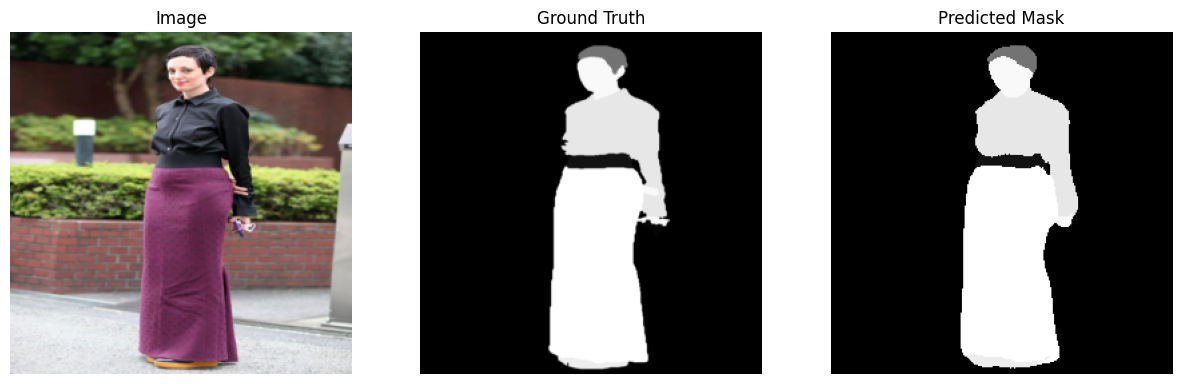

In [36]:
# 시각화 함수
def visualize(image_tensor, mask_tensor, pred_tensor, mean, std):
    image = denormalize(image_tensor, mean, std)  # 정규화 역변환 적용
    
    mask = mask_tensor.squeeze(0).cpu().numpy()  # Remove the channel dimension
    # mask = (mask * 255).astype(np.uint8)
    
    pred = pred_tensor.argmax(dim=0).cpu().numpy()  # 예측된 클래스
    # pred = (pred * 255 / pred.max()).astype(np.uint8)  # 정규화
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.show()

# 데이터셋에서 배치 하나를 로드하여 시각화
fcn_model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = fcn_model(images)
        
        # 정규화 역변환에 필요한 mean과 std
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        # 첫 번째 이미지와 마스크 시각화
        visualize(images[7], masks[7], outputs[7], mean, std)
        break  # 첫 번째 배치의 첫 번째 이미지만 시각화

# 6. mean IOU 구하기

In [50]:
def calculate_iou(pred, target, num_classes):
    ious = []
    # 비교를 위해 일차원으로 변환
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(1, num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection

        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in IoU
        else:
            ious.append(float(intersection) / float(union))
    
    if len(ious) != 0 and not np.all(np.isnan(ious)):
        return np.nanmean(ious)  # Return mean IoU for all classes
    else:
        return 0

# 전체 데이터셋에 대한 Mean IoU 계산
def mean_iou(model, data_loader, num_classes, device):
    model.eval()
    iou_list = []

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            # 예측 클래스 레이블을 얻음
            preds = outputs.argmax(dim=1)

            for pred, mask in zip(preds, masks.squeeze(1)):  # Remove channel dimension from masks
                iou = calculate_iou(pred, mask, num_classes)
                iou_list.append(iou)

    return np.nanmean(iou_list)

# 모델과 데이터 로더 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 59  # 클래스 수 설정
fcn_model.to(device)

# Mean IoU 계산
mean_iou_value = mean_iou(fcn_model, val_loader, num_classes, device)
print(f"Mean IoU: {mean_iou_value}")

Mean IoU: 0.10054701150414594


In [49]:
ious = np.nanmean([np.nan, np.nan, np.nan, 1])
print(ious)
print(np.all(np.isnan(ious)))

1.0
False


# 7. 모델 저장

In [33]:
# torch.save(fcn_model.state_dict(), 'fcn_model_weight.pt')

## 불러올때
fcn_model =FCN8s(n_class=59)
fcn_model.load_state_dict((torch.load('fcn_model_weight.pt')))

<All keys matched successfully>

# + 연습

In [109]:
y=torch.tensor([[1,2],[3,4]])
y.long().sum().item()

10

In [62]:
# 5x5 그리드 생성
og = np.ogrid[:5, :5]
print("og[0]:\n", og[0])
print("og[1]:\n", og[1])
print(og)

og[0]:
 [[0]
 [1]
 [2]
 [3]
 [4]]
og[1]:
 [[0 1 2 3 4]]
[array([[0],
       [1],
       [2],
       [3],
       [4]]), array([[0, 1, 2, 3, 4]])]


In [ ]:
kernel_size = 7
factor = (kernel_size + 1) // 2
if kernel_size % 2 == 1:
    center = factor - 1
else:
    center = factor - 0.5
# 그리드 생성
# ogrid -> 열린 그리드 생성
og = np.ogrid[:kernel_size, :kernel_size]
# 양선형 보간 필터 생성
filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
print(filt)